In [67]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from pathlib import Path
from dotenv import load_dotenv

import os

from scipy import ndimage
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from yolov5.utils.plots import Annotator, save_one_box
from ultralytics import YOLO

from utils.preprocess import recovery_rotated_bounding
from utils.yolo import get_teeth_ROI, crop_by_xyxy
from utils.edge import gum_jaw_separation, vertical_separation, get_rotation_angle, consecutive

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline

YOLO_model_dir = Path(os.getenv('YOLO_MODEL_DIR'))

# TODO 008140 008225 tooth missing


In [68]:
# model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
model = YOLO(YOLO_model_dir / '8-bound-v8.pt')

tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}
all_tooth_number_dict = {
    'upper': {
        'left': {0: 16, 1: 15, 2: 14},
        'middle': {0: 12, 1: 11, 2: 21, 3: 22},
        'right': {0: 24, 1: 25, 2: 26},
    },
    'lower': {
        'left': {0: 46, 1: 45, 2: 44},
        'middle': {0: 42, 1: 41, 2: 31, 3: 32},
        'right': {0: 34, 1: 35, 2: 36},
    }
}

# data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir = Path(os.getenv('DATASET_DIR')) / 'DENTEX CHALLENGE 2023/training_data/quadrant_enumeration/xrays'


/Users/lucyxu/PycharmProjects/datasets/DENTEX CHALLENGE 2023/training_data/quadrant_enumeration/xrays/train_172.png


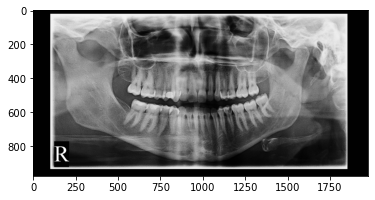

In [69]:
image_number = 0
# image_names = list(data_dir.glob('*00008026.jpg'))
image_names = list(data_dir.glob('*.png'))

image_name = image_names[0]
filename = image_name.stem
im = cv2.imread(image_name)

print(image_name)

plt.imshow(im, cmap='gray')
plt.show()


In [70]:
results = model(image_name)



image 1/1 /Users/lucyxu/PycharmProjects/datasets/DENTEX CHALLENGE 2023/training_data/quadrant_enumeration/xrays/train_172.png: 320x640 1 13, 1 17, 1 23, 1 27, 1 33, 2 37s, 1 43, 1 47, 62.5ms
Speed: 2.6ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


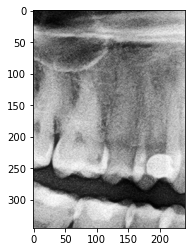

{'flag': 'upper',
 'tooth_position': 'left',
 'org_file_name': 'train_172',
 'offset': array([604, 252], dtype=int32),
 'padding': {'left': tensor([50.]), 'right': tensor([33.])},
 'image': array([[[ 44,  44,  44],
         [ 34,  34,  34],
         [ 31,  31,  31],
         ...,
         [176, 176, 176],
         [164, 164, 164],
         [165, 165, 165]],
 
        [[ 30,  30,  30],
         [ 32,  32,  32],
         [ 28,  28,  28],
         ...,
         [181, 181, 181],
         [160, 160, 160],
         [167, 167, 167]],
 
        [[ 19,  19,  19],
         [ 21,  21,  21],
         [ 26,  26,  26],
         ...,
         [177, 177, 177],
         [182, 182, 182],
         [183, 183, 183]],
 
        ...,
 
        [[116, 116, 116],
         [105, 105, 105],
         [108, 108, 108],
         ...,
         [174, 174, 174],
         [176, 176, 176],
         [162, 162, 162]],
 
        [[136, 136, 136],
         [126, 126, 126],
         [127, 127, 127],
         ...,
         [17

In [71]:
teeth_roi = get_teeth_ROI(results, yolov8=True)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']

target_roi = teeth_roi_images[0]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = target_roi['tooth_position']
im_g = cv2.cvtColor(target_roi_image, cv2.COLOR_RGBA2GRAY)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])

plt.imshow(im_g, cmap='gray')
plt.show()

target_roi


Erode to make gap bigger

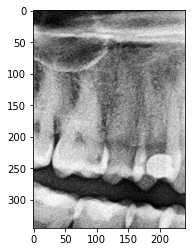

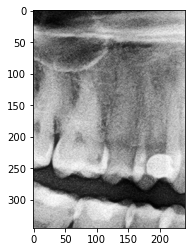

In [72]:
source = im_g
clahe = cv2.createCLAHE(clipLimit=0.6)

source = clahe.apply(source)

plt.gray()
plt.imshow(source)
plt.show()

plt.gray()
plt.imshow(im_g)
plt.show()


Rotate image to make tooth vertical

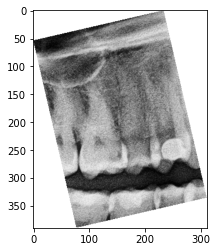

In [73]:
theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
source_rotated = ndimage.rotate(source, theta, reshape=True, cval=255)

plt.imshow(source_rotated, cmap='gray')
plt.show()


Zoom-in the crowns and discard the roots

57 32
198 300


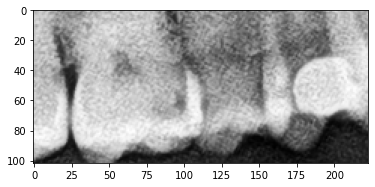

In [74]:
gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source_rotated, flag=flag)

height, width = source.shape
phi = np.radians(abs(theta))
opposite = np.sin(phi) * width
adjacent = np.cos(phi) * height

if flag == 'upper':
    source_roi = source_rotated[gum_sep_line:jaw_sep_line, :]
    y1 = gum_sep_line
    y2 = jaw_sep_line
elif flag == 'lower':
    source_roi = source_rotated[jaw_sep_line:gum_sep_line, :]
    y1 = jaw_sep_line
    y2 = gum_sep_line
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

left_padding, right_padding = 0, 1
if theta > 0:
    left_padding = round((y2 - opposite) * np.tan(phi))
    right_padding = round((adjacent - y1) * np.tan(phi))
elif theta < 0:
    left_padding = round((adjacent - y1) * np.tan(phi))
    right_padding = round((y2 - opposite) * np.tan(phi))
source_roi = source_roi[:, left_padding:-right_padding]
print(left_padding, right_padding)
print(gum_sep_line, jaw_sep_line)

plt.imshow(source_roi, cmap='gray')
plt.show()


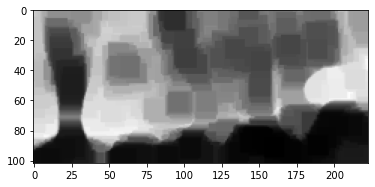

In [75]:
source_roi_filtered = source_roi
size = 5
kernel = np.ones((size, size), np.uint8)
source_roi_filtered = cv2.erode(source_roi_filtered, kernel, iterations=3)
# source_roi_filtered = gaussian_filter(source_roi_filtered, sigma=3)

plt.imshow(source_roi_filtered)
plt.show()


[]


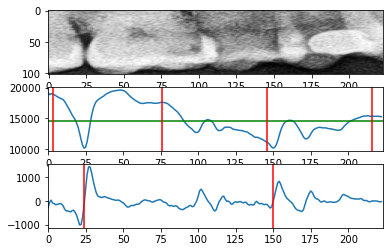

[ 24 150]


In [76]:
tooth_type = 'incisor' if tooth_position == 'middle' else 'molar'
window_position, valleys, ver, ver_slope = vertical_separation(source_roi, flag=flag, tooth_type=tooth_type,
                                                               angle=theta)
# window_position, valleys, ver, ver_slope = vertical_separation(source_roi_filtered, flag=flag, tooth_type=tooth_type,
#                                                                angle=theta)

# Missing tooth detection
ver_mean = np.median(ver)
tooth_missing_region = []
for i in range(ver.shape[0] - 1):
    is_derivative_smooth = abs(ver_slope[i] - ver_slope[i + 1]) < 45
    curve_under_mean = ver[i] < ver_mean

    if is_derivative_smooth and curve_under_mean:
        tooth_missing_region.append(i)
tooth_missing_region = consecutive(tooth_missing_region)
tooth_missing_region = [(i[0], i[-1]) for i in tooth_missing_region if len(i) > 60]
print(tooth_missing_region)

# Delete redundant valley
peaks = []
for missing_region in tooth_missing_region:
    peaks, _ = find_peaks(ver_slope[missing_region[0]:missing_region[1]], height=0)
    if len(peaks) < 1 or ver_slope[peaks + missing_region[0]].max() > 100:
        continue

    valley_between_missing_tooth = ((missing_region[0] < valleys) & (valleys < missing_region[1]))
    valley_near_missing_tooth = np.logical_or(np.abs(valleys - missing_region[0]) < 20,
                                              np.abs(valleys - missing_region[1]) < 20)
    valley_need_delete = np.logical_or(valley_between_missing_tooth, valley_near_missing_tooth)

    valleys = valleys[~valley_need_delete]
    valleys = np.append(valleys, missing_region)

valleys.sort()
bounding_number = len(valleys) - 1

# Plot area
fig, axs = plt.subplots(3, 1)
axs[0].imshow(source_roi, aspect='auto', cmap='gray')

height, width = source_roi.shape

axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_xlim(xmin=0, xmax=width)
axs[1].plot(ver)
axs[1].axhline(y=ver_mean, color='g')
for p in window_position:
    axs[1].axvline(x=p, color='r')

axs[2].xaxis.set_ticks_position('bottom')
axs[2].set_xlim(xmin=0, xmax=width)
axs[2].plot(ver_slope)
if peaks:
    peaks += missing_region[0]
    axs[2].plot(peaks, ver_slope[peaks], "x")
for p in valleys:
    axs[2].axvline(x=p, color='r')

plt.show()
print(valleys)


In [77]:
# peaks, _ = find_peaks(ver_slope[missing_region[0]:missing_region[1]], height=0)
# peaks, _ = find_peaks(ver_slope[valleys[2]:valleys[3]], height=0)
# ver_slope[peaks + missing_region[0]]


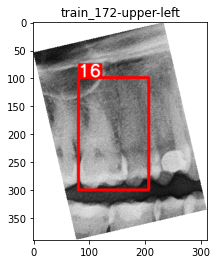

In [78]:
rotation_fix = False

tooth_number_dict = all_tooth_number_dict[flag][tooth_position]
if flag == 'upper':
    y1, y2 = gum_sep_line // 2, jaw_sep_line
elif flag == 'lower':
    y1, y2 = jaw_sep_line, gum_sep_line * 2
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

unknown_counter = 50
crop_regions = {}
tooth_missing_left_bound = {i[0] for i in tooth_missing_region}

for missing_region in range(bounding_number):
    is_missing = valleys[missing_region] in tooth_missing_left_bound

    x1 = valleys[missing_region] + left_padding
    x2 = valleys[missing_region + 1] + left_padding
    xyxy = torch.Tensor([x1, y1, x2, y2])

    try:
        tooth_number = tooth_number_dict[missing_region]
    except KeyError:
        tooth_number = unknown_counter
        unknown_counter += 1

    # FIXME recovery_rotated_bounding broken
    if rotation_fix:
        crop_source = source
        shape_h, shape_w = source.shape
        xyxy = np.vstack([xyxy, xyxy])
        xyxy = recovery_rotated_bounding(phi, (shape_w, shape_h), xyxy)[0]
    else:
        crop_source = source_rotated

    save_filename = f'{filename}-{tooth_number}'
    save_file = Path(f'./crops/{save_filename}.jpg')
    save = False
    crop_image = crop_by_xyxy(crop_source, xyxy.int(), save=save, file=save_file)
    crop_regions[tooth_number] = {'xyxy': xyxy, 'is_missing': is_missing, 'crop_image': crop_image}

# Plot bounding result
if rotation_fix:
    source_rgb = cv2.cvtColor(source, cv2.COLOR_GRAY2RGB)
else:
    im_g_rotated = ndimage.rotate(im_g, theta, reshape=True, cval=255)
    source_rgb = cv2.cvtColor(im_g_rotated, cv2.COLOR_GRAY2RGB)
    # source_rgb = cv2.cvtColor(source_rotated, cv2.COLOR_GRAY2RGB)
annotator = Annotator(source_rgb, line_width=3, example=filename)
for tooth_number, body in crop_regions.items():
    xyxy = body['xyxy']
    annotator.box_label(xyxy, str(tooth_number), color=(255, 0, 0))

im1 = annotator.result()

plt.imshow(im1)
plt.title(f'{filename}-{flag}-{tooth_position}')
plt.show()


{'xyxy': tensor([ 81.,  99., 207., 300.]), 'is_missing': False, 'crop_image': array([[ 93,  68,  44, ...,  81, 106, 145],
       [ 69,  46,  39, ...,  76, 103, 131],
       [ 57,  63,  64, ...,  99, 122, 133],
       ...,
       [ 55,  45,  48, ...,  30,  30,  34],
       [ 39,  36,  52, ...,  28,  30,  31],
       [ 40,  56,  74, ...,  24,  32,  34]], dtype=uint8)}


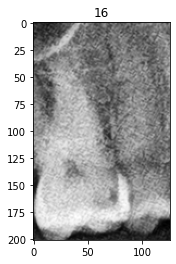

In [79]:
for tooth_number, data in crop_regions.items():
    print(data)
    crop_image = data['crop_image']

    plt.imshow(crop_image, cmap='gray')
    plt.title(tooth_number)
    plt.show()

